https://www.gdeltproject.org/data/lookups/FIPS.country.txt

In [6]:
country_code = 'YM'

In [5]:
from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [126]:
credentials = service_account.Credentials.from_service_account_file(
    '../keys/projecttest-318006-34f075e5bede.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

query = f"""
SELECT SQLDATE, EventCode
FROM `gdelt-bq.gdeltv2.events` 
WHERE ActionGeo_CountryCode = @country
ORDER BY SQLDATE DESC
LIMIT 500000
"""

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("country", "STRING", country_code)
    ]
)
query_job = client.query(query, job_config=job_config) 

In [162]:
country_df = query_job.to_dataframe()

humanitarian_crisis_events = ['0233', '0243', '0333', '0343', '0243', '073', '074', '0833', '0861', '0863',
                              '092', '094', '103', '1033', '1043', '1122', '1124', '1233', '137', '138', 
                              '1382', '1383', '1384', '1385', '1413', '1423', '1451', '1452', '1453', '1454', 
                              '175', '18', '180', '181', '182', '1821', '1822', '1823', '183', '1831', '1832', 
                              '1833', '184']

country_df['IsHumanitarianCrisis'] = country_df.EventCode.isin(humanitarian_crisis_events)

country_df.SQLDATE = pd.to_datetime(country_df.SQLDATE, format='%Y%m%d', errors='ignore')
country_df = country_df.set_index('SQLDATE')
country_df_grouped = country_df['IsHumanitarianCrisis'].groupby(pd.Grouper(freq='7d')).agg(['sum','count','mean'])

country_df_grouped.columns = ['HumanitarianCrisisEvents', 'TotalEvents', 'HumanitarianCrisisProportions']
humanitarian_crisis_ts = country_df_grouped.HumanitarianCrisisProportions

In [163]:
lookup_df = pd.read_csv('../data/country_code_lookup.csv')
country_name = lookup_df[lookup_df['Country Code'] == country_code].Country.values[0]

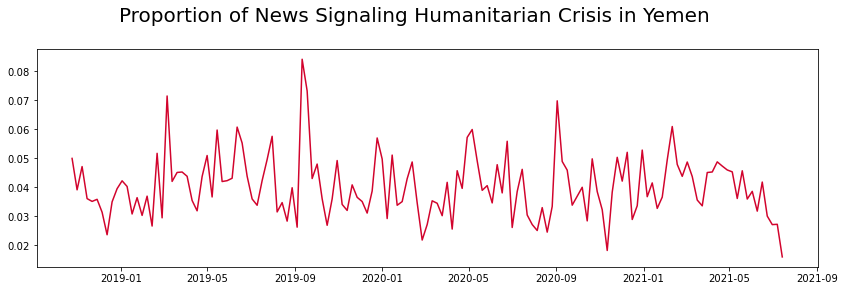

In [164]:
plt.figure(figsize=(14, 4))
plt.figtext(.5,.9,f'Proportion of News Signaling Humanitarian Crisis in {country_name}\n', fontsize=20, ha='center')
plt.plot(humanitarian_crisis_ts, color='#D2042D') ;

Results of Dickey-Fullter Test:
Test Statistic          -9.210483e+00
p-value                  1.893648e-15
# Lags Used              0.000000e+00
# of Obs Used            1.420000e+02
Critiical Values: 1%    -3.477262e+00
Critiical Values: 5%    -2.882118e+00
Critiical Values: 10%   -2.577743e+00
dtype: float64


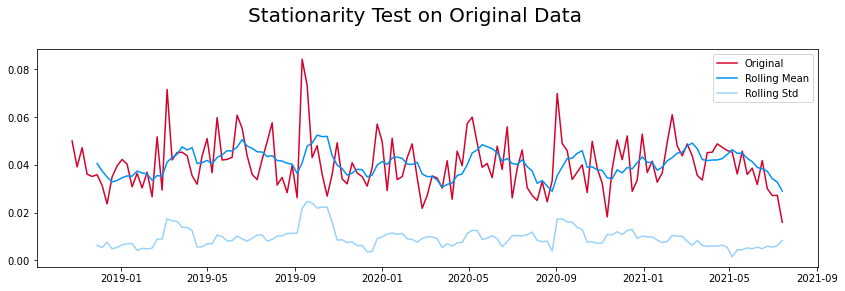

In [165]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(ts, window=30, title='Stationarity Test'):
    print('Results of Dickey-Fullter Test:')
    dftest = adfuller(ts, autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# of Obs Used'])
    for k, v in dftest[4].items():
        dfoutput[f'Critiical Values: {k}'] = v
    
    print(dfoutput)
        
    rollmean = ts.rolling(window=window).mean()
    rollstd = ts.rolling(window=window).std()
    
    plt.figure(figsize=(14, 4))
    original = plt.plot(ts, color = '#D2042D', label = 'Original')
    mean = plt.plot(rollmean, color = '#0092F4', label = 'Rolling Mean')
    std = plt.plot(rollstd, color = '#99d3fb', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.figtext(.5,.9,f'{title}\n', fontsize=20, ha='center')


stationarity_test(humanitarian_crisis_ts, window=6, title='Stationarity Test on Original Data')

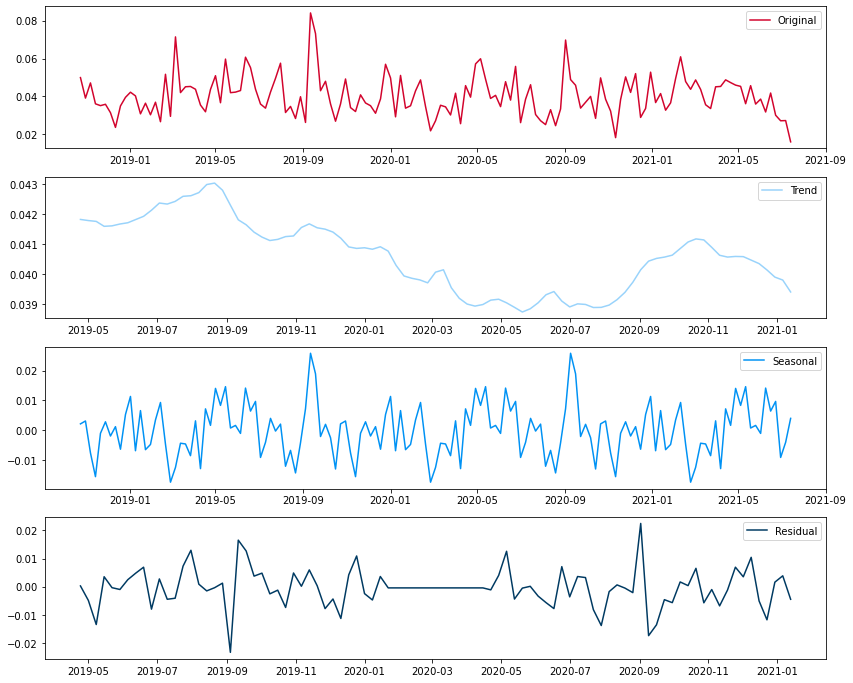

In [167]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(humanitarian_crisis_ts)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14,12))
plt.subplot(411)
plt.plot(humanitarian_crisis_ts, label = 'Original', color = '#D2042D')
plt.legend()
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = '#99d3fb')
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal', color = '#0092F4')
plt.legend()
plt.subplot(414)
plt.plot(residual, label = 'Residual', color = '#003a62')
plt.legend(loc='upper right')

Results of Dickey-Fullter Test:
Test Statistic           -3.406426
p-value                   0.010742
# Lags Used               6.000000
# of Obs Used            84.000000
Critiical Values: 1%     -3.510712
Critiical Values: 5%     -2.896616
Critiical Values: 10%    -2.585482
dtype: float64


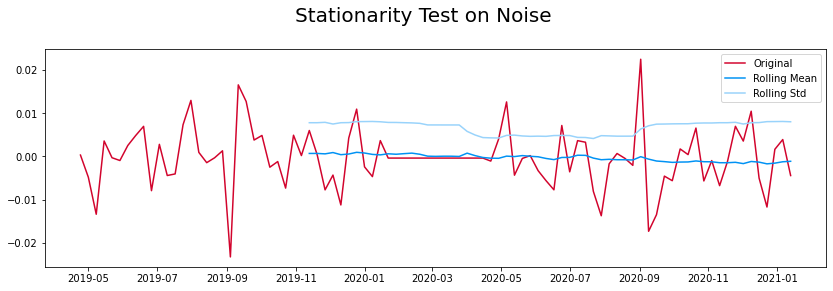

In [168]:
stationarity_test(residual.dropna(), title='Stationarity Test on Noise')

In [169]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [170]:
stepwise_fit = auto_arima(humanitarian_crisis_ts, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-887.201, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-886.188, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-891.651, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-890.399, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-500.644, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-890.148, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-889.631, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-888.582, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-827.286, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.668 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 448.825
Date:                Thu, 15 Jul 2021   AIC                           -891.651
Time:                        18:25:41   BIC                           -882.762
Sample:                             0   HQIC                          -888.039
                                - 143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0310      0.003      9.971      0.000       0.025       0.037
ar.L1          0.2299      0.073      3.150      0.002       0.087       0.373
sigma2         0.0001   1.04e-05     10.613      0.000    8.96e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                66.05
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.07
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [171]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(humanitarian_crisis_ts, order=stepwise_fit.order)
model = model.fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    ARMA Model Results                                   
=========================================================================================
Dep. Variable:     HumanitarianCrisisProportions   No. Observations:                  143
Model:                                ARMA(1, 0)   Log Likelihood                 448.825
Method:                                  css-mle   S.D. of innovations              0.010
Date:                           Thu, 15 Jul 2021   AIC                           -891.651
Time:                                   18:25:45   BIC                           -882.762
Sample:                               10-24-2018   HQIC                          -888.039
                                    - 07-14-2021                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.0403      0.001     35.478      0.000       0.038       0.043
ar.L1.HumanitarianCrisisProportions     0.2295      0.083      2.769      0.006       0.067       0.392
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.3579           +0.0000j            4.3579            0.0000
-----------------------------------------------------------------------------
"""

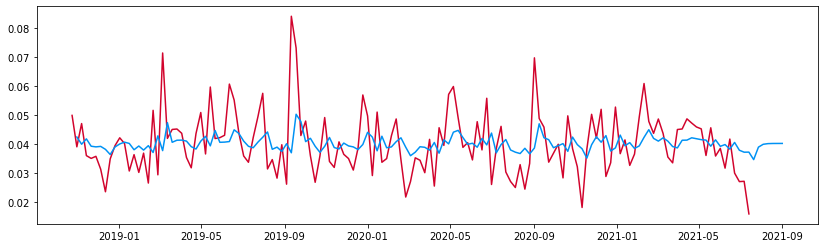

In [172]:
end=len(humanitarian_crisis_ts)
pred = model.predict(start=1, end=end+6)

plt.figure(figsize=(14,4))
plt.plot(humanitarian_crisis_ts, color='#D2042D')
plt.plot(pred, color='#0092F4')